**Project: Credit Card Fraud Detection**

Name: Kanchan Santosh Kad.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from collections import Counter

In [2]:
cc_info = pd.read_csv("cc_info.csv")  
transactions = pd.read_csv("transactions.csv") 

In [3]:

# Merge both datasets on 'credit_card'
data = transactions.merge(cc_info, on="credit_card", how="left")

In [4]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   date                       294588 non-null  object 
 2   transaction_dollar_amount  294588 non-null  float64
 3   Long                       294588 non-null  float64
 4   Lat                        294588 non-null  float64
 5   city                       294588 non-null  object 
 6   state                      294588 non-null  object 
 7   zipcode                    294588 non-null  int64  
 8   credit_card_limit          294588 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 20.2+ MB
None
        credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08             

In [5]:
data.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
dtype: int64

In [6]:
# Fill missing values if any
data.fillna(method="ffill", inplace=True)

C:\Users\kanchan\AppData\Local\Temp\ipykernel_27144\3262625794.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)


In [7]:
# Encoding categorical variables (city, state)
data = pd.get_dummies(data, columns=["city", "state"], drop_first=True)

In [8]:
# Feature Scaling for Amount and Credit Limit
scaler = StandardScaler()
data["transaction_dollar_amount"] = scaler.fit_transform(data["transaction_dollar_amount"].values.reshape(-1, 1))
data["credit_card_limit"] = scaler.fit_transform(data["credit_card_limit"].values.reshape(-1, 1))

In [9]:
# Define X (features) and y (target)
X = data.drop(columns=["credit_card", "date"])  # Drop unnecessary columns
y = (data["transaction_dollar_amount"] > data["credit_card_limit"]).astype(int)  # Label Fraud if amount > limit


In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:
# Handling class imbalance using SMOTE
print("\nBefore SMOTE: ", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE: ", Counter(y_train_res))


Before SMOTE:  Counter({1: 105377, 0: 100834})
After SMOTE:  Counter({0: 105377, 1: 105377})


In [13]:
# Train RandomForest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_res, y_train_res)
y_pred_rfc = rfc.predict(X_test)

In [14]:
# Evaluate RandomForest Model
print("\nRandom Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rfc))
print("Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rfc))


Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43221
           1       1.00      1.00      1.00     45156

    accuracy                           1.00     88377
   macro avg       1.00      1.00      1.00     88377
weighted avg       1.00      1.00      1.00     88377

Accuracy: 0.9991061022664268
ROC AUC Score: 0.9991173230749367


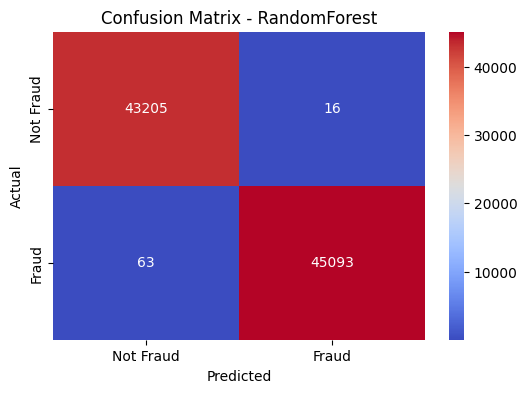

In [15]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rfc), annot=True, fmt="d", cmap="coolwarm", xticklabels=["Not Fraud", "Fraud"], 
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RandomForest")
plt.show()

In [16]:
# Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(X_train)
y_pred_if = iso_forest.predict(X_test)
y_pred_if = [1 if x == -1 else 0 for x in y_pred_if]


In [17]:
# Evaluate Isolation Forest Model
print("\nIsolation Forest Performance:")
print(classification_report(y_test, y_pred_if))
print("Accuracy:", accuracy_score(y_test, y_pred_if))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_if))


Isolation Forest Performance:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66     43221
           1       0.21      0.00      0.00     45156

    accuracy                           0.49     88377
   macro avg       0.35      0.50      0.33     88377
weighted avg       0.35      0.49      0.32     88377

Accuracy: 0.48865655091256777
ROC AUC Score: 0.4995886598085646


In [ ]:
# Hyperparameter Tuning for RandomForest
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

In [ ]:
# Best Hy# Best Hyperparameters
print("\nBest Hyperparameters for RandomForest:")
print(grid_search.best_params_)